# LLMs Alignment with Reinforcement Learning from human feedback (RLHF).

During this lesson we will learn:
- What open source libraries may be useful to align your LLM.
- How LLM alignment pipeline looks like (steps, components, models, metrics).
- Explore example of GPT2 alignment with the task to generate more positive reviews.
- How to inspect aligned model and look up examples before/after alignment.





For this lesson we would need several libraries, most of them we already seen during previous tutorials (```torch, transformers, peft```). A new lib is ```trl``` which is also developed by HuggingFsce and stends for Transformers Reinforcement Learning.

Read more in the docs https://huggingface.co/docs/trl

TRL provides implementation of various components requried to run an LLM alignment pipeline with RLHF (Supervised finetunine, reward training, proximal policy optimization etc).

It also has code examples for different alignment problems https://huggingface.co/docs/trl/index#examples

The code below is actually from the examples page https://huggingface.co/docs/trl/sentiment_tuning with minor modifications (e.g. gpt2 is wrapped into PEFT).



In [ ]:
from PIL import Image
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


### Our task is to align model to generate more positive movie reviews.

What we will need:

* 1) Data: imdb dataset
* 2) Generative model to be aligned: gpt2 finetuned on imdb data
* 3) Reference model: gpt2 finetuned on imdb data (not aligned)
* 4) Reward model: distill BERT finetuned on imdb data for sentiment analysis
* 5) Reinforcement Learning Strategy: Proximal Policy Optimization (PPO)


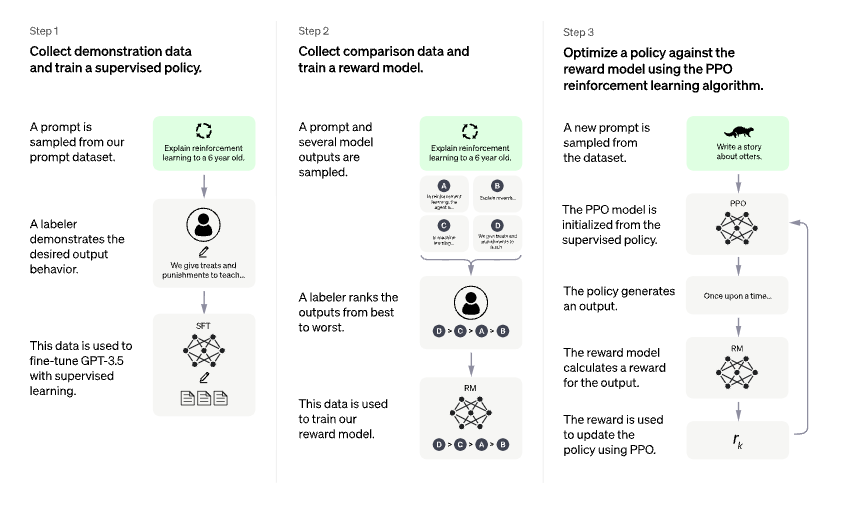

In [ ]:
# source https://openai.com/blog/chatgpt

Image.open("/content/drive/MyDrive/oxford_llms_practice/day_3/images/rlhf_pipeline.png")

## Experiment details

Above is the pipeline for LLM alignment with RLHF

We will refer to it in our example with the following details:
* In terms of step 1 we will not train a supervised policy by ourselves but will use already finetuned open source model for our dataset.
* In terms of step 2, because we have no time to do manual labelling and training a reward model, we will use one of the open source models as a reward classifier.
* Step 3 will be implemented as is.

# Tune GPT2 to generate positive reviews
> Optimise GPT2 to produce positive IMDB movie reviews using a BERT sentiment classifier as a reward function.

<div style="text-align: center">
<img src='https://huggingface.co/datasets/trl-internal-testing/example-images/resolve/main/images/gpt2_bert_training.png' width='600'>
<p style="text-align: center;"> <b>Figure:</b> Experiment setup to tune GPT2. The yellow arrows are outside the scope of this notebook, but the trained models are available through Hugging Face. </p>
</div>


In this notebook we fine-tune GPT2 (small) to generate positive movie reviews based on the IMDB dataset. The model gets the start of a real review and is tasked to produce positive continuations. To reward positive continuations we use a BERT classifier to analyse the sentiment of the produced sentences and use the classifier's outputs as rewards signals for PPO training.

## Setup experiment

### Import dependencies

In [ ]:
!pip install transformers==4.33.1
!pip install datasets==2.14.4
!pip install peft==0.5.0
!pip install trl==0.7.1

In [ ]:
import torch
from tqdm import tqdm
import pandas as pd

tqdm.pandas()

from transformers import pipeline, AutoTokenizer, GPT2LMHeadModel
from datasets import load_dataset

from trl import PPOTrainer, PPOConfig, AutoModelForCausalLMWithValueHead
from trl.core import LengthSampler

from peft import get_peft_model, LoraConfig, TaskType

### Configuration

In [ ]:
config = PPOConfig(
    model_name="lvwerra/gpt2-imdb",
    learning_rate=1.41e-5,
    log_with="wandb",
)

sent_kwargs = {"return_all_scores": True, "function_to_apply": "none", "batch_size": 16}

In [ ]:
import wandb

wandb.init()

<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


You can see that we load a GPT2 model called `gpt2_imdb`. This model was additionally fine-tuned on the IMDB dataset for 1 epoch with the huggingface [script](https://github.com/huggingface/transformers/blob/master/examples/run_language_modeling.py) (no special settings). The other parameters are mostly taken from the original paper ["Fine-Tuning Language Models from Human Preferences"](
https://arxiv.org/pdf/1909.08593.pdf). This model as well as the BERT model is available in the Huggingface model zoo [here](https://huggingface.co/models). The following code should automatically download the models.

## Load data and models

### Load IMDB dataset
The IMDB dataset contains 50k movie review annotated with "positive"/"negative" feedback indicating the sentiment.  We load the IMDB dataset into a DataFrame and filter for comments that are at least 200 characters. Then we tokenize each text and cut it to random size with the `LengthSampler`.

In [ ]:
def build_dataset(
    config, dataset_name="imdb", input_min_text_length=2, input_max_text_length=8
):
    """
    Build dataset for training. This builds the dataset from `load_dataset`, one should
    customize this function to train the model on its own dataset.

    Args:
        dataset_name (`str`):
            The name of the dataset to be loaded.

    Returns:
        dataloader (`torch.utils.data.DataLoader`):
            The dataloader for the dataset.
    """
    tokenizer = AutoTokenizer.from_pretrained(config.model_name)
    tokenizer.pad_token = tokenizer.eos_token
    # load imdb with datasets
    ds = load_dataset(dataset_name, split="train")
    ds = ds.rename_columns({"text": "review"})
    ds = ds.filter(lambda x: len(x["review"]) > 200, batched=False)

    input_size = LengthSampler(input_min_text_length, input_max_text_length)

    def tokenize(sample):
        sample["input_ids"] = tokenizer.encode(sample["review"])[: input_size()]
        sample["query"] = tokenizer.decode(sample["input_ids"])
        return sample

    ds = ds.map(tokenize, batched=False)
    ds.set_format(type="torch")
    return ds

In [ ]:
dataset = build_dataset(config)


def collator(data):
    return dict((key, [d[key] for d in data]) for key in data[0])

### Load pre-trained GPT2 language models

We load the GPT2 model with a value head and the tokenizer. We load the model twice; the first model is optimized while the second model serves as a reference to calculate the KL-divergence from the starting point. This serves as an additional reward signal in the PPO training to make sure the optimized model does not deviate too much from the original language model.

In [ ]:
model = GPT2LMHeadModel.from_pretrained(config.model_name)


peft_config = LoraConfig(
    task_type=TaskType.CAUSAL_LM,
    inference_mode=False,
    r=32,
    lora_alpha=32,
    lora_dropout=0.1,
)

peft_model = get_peft_model(model, peft_config)
peft_model.print_trainable_parameters()

/usr/local/lib/python3.10/dist-packages/peft/tuners/lora.py:475: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


trainable params: 1,179,648 || all params: 125,619,456 || trainable%: 0.939064725769868


In [ ]:
model = AutoModelForCausalLMWithValueHead.from_pretrained(peft_model, is_trainable=True)

ref_model = AutoModelForCausalLMWithValueHead.from_pretrained(config.model_name)
tokenizer = AutoTokenizer.from_pretrained(config.model_name)

tokenizer.pad_token = tokenizer.eos_token

### Initialize PPOTrainer
The `PPOTrainer` takes care of device placement and optimization later on:

In [ ]:
ppo_trainer = PPOTrainer(
    config, model, ref_model, tokenizer, dataset=dataset, data_collator=collator
)

### Load BERT classifier
We load a BERT classifier fine-tuned on the IMDB dataset.

In [ ]:
device = ppo_trainer.accelerator.device
if ppo_trainer.accelerator.num_processes == 1:
    device = 0 if torch.cuda.is_available() else "cpu"  # to avoid a `pipeline` bug
sentiment_pipe = pipeline(
    "sentiment-analysis", model="lvwerra/distilbert-imdb", device=device
)

The model outputs are the logits for the negative and positive class. We will use the logits for positive class as a reward signal for the language model.

In [ ]:
text = "this movie was really bad!!"
sentiment_pipe(text, **sent_kwargs)

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


[[{'label': 'NEGATIVE', 'score': 2.3350486755371094},
  {'label': 'POSITIVE', 'score': -2.726576566696167}]]

In [ ]:
text = "this movie was really good!!"
sentiment_pipe(text, **sent_kwargs)

[[{'label': 'NEGATIVE', 'score': -2.294790267944336},
  {'label': 'POSITIVE', 'score': 2.557040214538574}]]

### Generation settings
For the response generation we just use sampling and make sure top-k and nucleus sampling are turned off as well as a minimal length.

In [ ]:
gen_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}

## Optimize model

### Training loop

The training loop consists of the following main steps:
1. Get the query responses from the policy network (GPT-2)
2. Get sentiments for query/responses from BERT
3. Optimize policy with PPO using the (query, response, reward) triplet

**Training time**

This step takes **~30min** on a T4 GPU with the above specified settings.

In [ ]:
output_min_length = 4
output_max_length = 16
output_length_sampler = LengthSampler(output_min_length, output_max_length)


generation_kwargs = {
    "min_length": -1,
    "top_k": 0.0,
    "top_p": 1.0,
    "do_sample": True,
    "pad_token_id": tokenizer.eos_token_id,
}

num_steps = 10

for epoch, batch in tqdm(enumerate(ppo_trainer.dataloader)):
    if epoch >= num_steps:
        break

    query_tensors = batch["input_ids"]

    #### Get response from gpt2
    response_tensors = []
    for query in query_tensors:
        gen_len = output_length_sampler()
        generation_kwargs["max_new_tokens"] = gen_len
        response = ppo_trainer.generate(query, **generation_kwargs)
        response_tensors.append(response.squeeze()[-gen_len:])
    batch["response"] = [tokenizer.decode(r.squeeze()) for r in response_tensors]

    #### Compute sentiment score
    texts = [q + r for q, r in zip(batch["query"], batch["response"])]
    pipe_outputs = sentiment_pipe(texts, **sent_kwargs)
    rewards = [torch.tensor(output[1]["score"]) for output in pipe_outputs]

    #### Run PPO step
    stats = ppo_trainer.step(query_tensors, response_tensors, rewards)

    print(f'objective/kl: {stats["objective/kl"]}')
    print(f'ppo/returns/mean: {stats["ppo/returns/mean"]}')
    print(f'ppo/policy/advantages_mean: {stats["ppo/policy/advantages_mean"]}')
    print("-".join("" for x in range(100)))

    ppo_trainer.log_stats(stats, batch, rewards)

0it [00:00, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


objective/kl: 0.4137515425682068
ppo/returns/mean: [0.46920103]
ppo/policy/advantages_mean: [0.0169361]
---------------------------------------------------------------------------------------------------


1it [01:31, 91.30s/it]

objective/kl: 0.5488318204879761
ppo/returns/mean: [0.5327836]
ppo/policy/advantages_mean: [0.0079108]
---------------------------------------------------------------------------------------------------


2it [03:05, 92.71s/it]

objective/kl: 0.7808701992034912
ppo/returns/mean: [0.6275819]
ppo/policy/advantages_mean: [-0.00011725]
---------------------------------------------------------------------------------------------------


3it [04:33, 90.92s/it]

objective/kl: 1.0051729679107666
ppo/returns/mean: [0.73939526]
ppo/policy/advantages_mean: [0.04590533]
---------------------------------------------------------------------------------------------------


4it [06:02, 90.01s/it]

objective/kl: 1.1486907005310059
ppo/returns/mean: [0.8533226]
ppo/policy/advantages_mean: [-0.01334301]
---------------------------------------------------------------------------------------------------


5it [07:34, 90.86s/it]/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


objective/kl: 1.313449740409851
ppo/returns/mean: [0.9962805]
ppo/policy/advantages_mean: [-0.00176718]
---------------------------------------------------------------------------------------------------


6it [09:03, 90.27s/it]

objective/kl: 1.808748722076416
ppo/returns/mean: [0.94268215]
ppo/policy/advantages_mean: [-0.02161223]
---------------------------------------------------------------------------------------------------


7it [10:33, 90.11s/it]

objective/kl: 1.6032769680023193
ppo/returns/mean: [1.0399033]
ppo/policy/advantages_mean: [-0.090289]
---------------------------------------------------------------------------------------------------


8it [12:02, 89.77s/it]

objective/kl: 1.8718605041503906
ppo/returns/mean: [1.0597236]
ppo/policy/advantages_mean: [-0.07203025]
---------------------------------------------------------------------------------------------------


9it [13:31, 89.50s/it]

objective/kl: 1.988152027130127
ppo/returns/mean: [1.0313241]
ppo/policy/advantages_mean: [-0.04487734]
---------------------------------------------------------------------------------------------------


10it [15:07, 90.72s/it]


## Model inspection
Let's inspect some examples from the IMDB dataset. We can use `model_ref` to compare the tuned model `model` against the model before optimisation.

In [ ]:
#### get a batch from the dataset
bs = 16
game_data = dict()
dataset.set_format("pandas")
df_batch = dataset[:].sample(bs)
game_data["query"] = df_batch["query"].tolist()
query_tensors = df_batch["input_ids"].tolist()

response_tensors_ref, response_tensors = [], []

#### get response from gpt2 and gpt2_ref
for i in range(bs):
    gen_len = output_length_sampler()
    output = ref_model.generate(
        torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
        max_new_tokens=gen_len,
        **gen_kwargs
    ).squeeze()[-gen_len:]
    response_tensors_ref.append(output)
    output = model.generate(
        input_ids=torch.tensor(query_tensors[i]).unsqueeze(dim=0).to(device),
        max_new_tokens=gen_len,
        **gen_kwargs
    ).squeeze()[-gen_len:]
    response_tensors.append(output)

#### decode responses
game_data["response (before)"] = [
    tokenizer.decode(response_tensors_ref[i]) for i in range(bs)
]
game_data["response (after)"] = [
    tokenizer.decode(response_tensors[i]) for i in range(bs)
]

#### sentiment analysis of query/response pairs before/after
texts = [q + r for q, r in zip(game_data["query"], game_data["response (before)"])]
game_data["rewards (before)"] = [
    output[1]["score"] for output in sentiment_pipe(texts, **sent_kwargs)
]

texts = [q + r for q, r in zip(game_data["query"], game_data["response (after)"])]
game_data["rewards (after)"] = [
    output[1]["score"] for output in sentiment_pipe(texts, **sent_kwargs)
]

# store results in a dataframe
df_results = pd.DataFrame(game_data)
df_results

/usr/local/lib/python3.10/dist-packages/transformers/pipelines/text_classification.py:105: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/pipelines/base.py:1101: UserWarning: You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset
  warnings.warn(


,query,response (before),response (after),rewards (before),rewards (after)
0,The choice to make this SNL,-style spoof in,version the best it,-0.875856,1.931428
1,I think I've seen this,movie before.<br /><br />,movie in lots of documentaries and holidays and,1.068866,1.891524
2,This is widely,commented on but apparently no one is much in...,"known as ""May 60"" still outstanding. It depicts",-0.728099,2.471262
3,I actually prefer Robin Williams,as Beau Sommers whose style was that of a hou...,"' ""Fantastic Four"" more this time around, alth...",0.343954,1.006784
4,INSPECTOR,CYPSE: ANO,", Cowboy and Gunslinger are great and have",-0.871963,2.524024
5,"Paulie was cute, cool",", inspiring, smart, good and inspiring. Genera...",and sexy at the same time and cut her heart in,2.609736,2.369741
6,This is one of those,"""Universal Legend movies"". Imagine giving the...",novels that is a great tribute to classic Hol...,0.862306,2.477181
7,From actor and independent,"publishing legend Frank Romineau, ""We Are the...","director Andrew Tru, the film makes an astoni...",0.556323,2.758821
8,Greenaway seems to,love Robinson who is visibly depressed,have found the perfect solution with,-0.061349,0.142887
9,"Whoo-boy, that was","neat. Still, Spell's skills were weak, the pl...","one of my best films of the year. It's stunning,",-2.384418,2.825216


Looking at the reward mean/median of the generated sequences we observe a significant difference.

In [ ]:
print("mean:")
display(df_results[["rewards (before)", "rewards (after)"]].mean())
print()
print("median:")
display(df_results[["rewards (before)", "rewards (after)"]].median())

mean:


rewards (before)    0.554885
rewards (after)     2.049240
dtype: float64


median:


rewards (before)    0.709314
rewards (after)     2.420502
dtype: float64